In [10]:
import src.functions as src

In [11]:
labels = {}
with open('labels.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(':')
        subject = parts[0].strip()
        data = parts[1].strip().split('][')
        data = [x.strip('[').strip(']').split(',') for x in data]
        data = [int(x) for sublist in data for x in sublist]
        labels[subject] = data

In [12]:
theta_features=src.load_dict_from_file('theta_features.txt')
frequency_features=src.load_dict_from_file('frequency_features.txt')
temporal_features=src.load_dict_from_file('temporal_features.txt')
all_features=src.load_dict_from_file('all_features.txt')

### Temporal

In [ ]:
src.classification('linear',temporal_features,labels)

### Theta

In [ ]:
src.classification('linear', theta_features, labels)

### Frequency

In [21]:
src.classification('linear', frequency_features, labels)

Mean score: 0.6898
Std score: 0.0269
-------------------------------
Mean score: 0.6795
Std score: 0.0188
-------------------------------
Mean score: 0.6981
Std score: 0.0235
-------------------------------
Mean score: 0.6954
Std score: 0.0302
-------------------------------
Mean score: 0.6704
Std score: 0.0154
-------------------------------
Mean score: 0.6905
Std score: 0.0388
-------------------------------
Mean score: 0.6763
Std score: 0.0214
-------------------------------
Mean score: 0.6849
Std score: 0.0143
-------------------------------
Mean score: 0.6796
Std score: 0.0148
-------------------------------
Mean score: 0.6859
Std score: 0.0243
-------------------------------
Mean score: 0.6841
Std score: 0.0206
-------------------------------
Mean score: 0.6840
Std score: 0.0221
-------------------------------
Mean score: 0.6766
Std score: 0.0256
-------------------------------
Mean score: 0.6902
Std score: 0.0218
-------------------------------
Mean score: 0.6866
Std score: 0.02

### All

In [25]:
src.classification('rbf', all_features, labels)

Mean score: 0.8087
Std score: 0.0158
-------------------------------
Mean score: 0.8127
Std score: 0.0153
-------------------------------
Mean score: 0.8200
Std score: 0.0137
-------------------------------
Mean score: 0.8116
Std score: 0.0136
-------------------------------
Mean score: 0.8110
Std score: 0.0249
-------------------------------
Mean score: 0.8232
Std score: 0.0158
-------------------------------
Mean score: 0.8176
Std score: 0.0154
-------------------------------
Mean score: 0.8262
Std score: 0.0136
-------------------------------
Mean score: 0.8210
Std score: 0.0082
-------------------------------
Mean score: 0.8171
Std score: 0.0133
-------------------------------
Mean score: 0.8120
Std score: 0.0160
-------------------------------
Mean score: 0.8182
Std score: 0.0172
-------------------------------
Mean score: 0.8091
Std score: 0.0122
-------------------------------
Mean score: 0.8117
Std score: 0.0123
-------------------------------
Mean score: 0.8150
Std score: 0.01

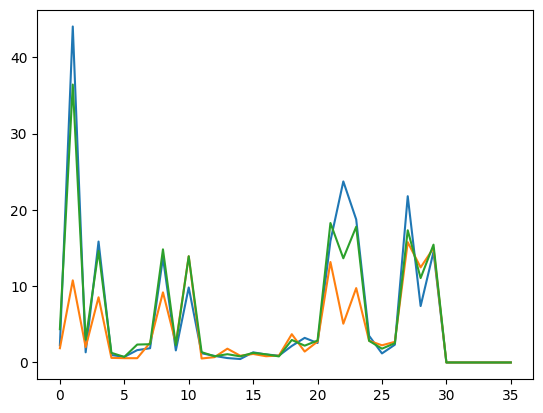

In [18]:
import matplotlib.pyplot as plt

plt.plot(all_features['P01'][4])
plt.plot(all_features['P01'][5])
plt.plot(all_features['P01'][6])